# Nix / Nixpkgs / NixOS

In this presentation when I refer to `nix` I am refering to the community of tools. `nix` is an ecosystem of tools and ideas that rethink packaging, development, OS configuration, containers, and configuration management in general. I hope that this presentation can show how `nix` can be used. Nix is compatible with Darwin (OSX) and all linux distributions (including ARM and FreeBSD).

To confuse things the community is based on a programming language called `nix`. Some noteable features.
  - functional programming language
  - lazy lazy evaluation (only evaluate once and never evaluate if not used)
  - evaluations are compatible with json/yaml representation
  
# Nix

In [14]:
import nix

nix.eval('''
let a = 1;
    b = { c = a; }.d;
    f = v: v + 1;
in
rec {
   x = a;
   y = f 11;
   z = [ (x + y) 10 ];
}
''')

{'x': 1, 'y': 12, 'z': [13, 10]}

The expression above shows many nix concepts. `let ... in` allows for local variable declarations outside of the returned expression. `rec` allows for recursive attribute definitions. `{ ... }` are equivalent to dictionaries. `[ ]` are lists. We also have a function declaration `f = v: v + 1;` which takes a given value and adds 1 to it.

Notice that there is an error in the expression above but it is not evaluated in nix so there is no problem. `b = { c = a; }.d;` -> `b = { c = 1; }.d;` -> "no d attribute in `{ c = 1; }`. This shows just how lazy nix is! For a much better introduction see [nix language primer](http://www.binaryphile.com/nix/2018/07/22/nix-language-primer.html). Nix fundamental types are ints, floats, strings, filepaths(including http://...), lists, and dicts. Note that filepaths are a type in nix which is one reason why nix is a great configuration language. Also supports `imports` that can be remote or local allowing truely composable configuration.

A question that many commonly come up is why not [yaml, json, or X](https://discourse.nixos.org/t/why-not-use-yaml-for-configuration-and-package-declaration/1333). Take a look around who is using plain `json` or `yaml` for package configuration? Conda uses `meta.yaml` which is yaml + jinja2. Teraform configuration is [HashiCorp Configuration Language (HCL)](https://www.terraform.io/docs/configuration/syntax.html) which is sometimes json "like". Ansible is `yaml` + jinja2 and their custom magic. The point is that configuration tools require **abstration** to remove the tedious work. It is my personal belief that `nix` is an excelent replacement for these with a strong theoretical backbone based on a [dissertation by Eelco Dolstra](https://grosskurth.ca/bib/2006/dolstra-thesis.pdf).

# Nixpkgs

[nixpkgs](https://github.com/NixOS/nixpkgs) is the realization of a purely functional package manager.

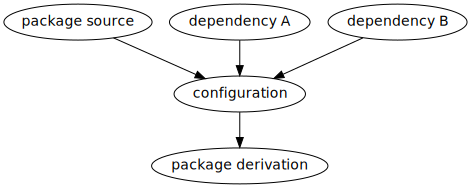

In [6]:
from graphviz import Digraph

dot = Digraph()
dot.node('A', 'configuration')
dot.node('B', 'package source')
dot.node('C', 'dependency A')
dot.node('D', 'dependency B')
dot.node('E', 'package derivation')
dot.edges(['BA', 'CA', 'DA', 'AE'])
dot

Nixpkgs applies the following constraints:
 - all packages are built in a sandboxed environment (no network, chroot with only dependencies in filepath, etc)
 - each package derivation is put in a flat read-only directory `/nix/store/<sha256>-<name>-<version>`
  
Interesting consequences:

1. If a package builds on your machine then it is nearly guarenteed to build on elsewhere (nixpkgs never sees issues of "it builds here but not there")
2. Since we have all dependecies packaged in a directory installation is simply downloading a tarball (no execution)
3. The sha256 hash of the configuration and its dependencies allows us to `cache` builds thus nix is a source and binary package manager
4. Easily support multiple versions of same package along with different configurations (e.g. single vs double precision)
5. Package builds can be distributed (since all dependencies are well defined)
6. Packages are now the new "Container"
7. All build configuration is completely reproducible and feasable to manage in source control

# Nixpkgs Derivation

What is a derivation? A derivation is a configuration for a given package that defines all dependencies and configuration to build a given package.

Example packaging `c` [xnd library](https://xnd.io/)

```nix
{ lib
, stdenv
, fetchFromGitHub
, libndtypes
}:

stdenv.mkDerivation rec {
  name = "libxnd-${version}";
  version = "0.2.0dev3";

  src = fetchFromGitHub {
    owner = "plures";
    repo = "xnd";
    rev = "v${version}";
    sha256 = "0byq7jspyr2wxrhihw4q7nf0y4sb6j5ax0ndd5dnq5dz88c7qqm2";
  };

  buildInputs = [ libndtypes ];

  # Override linker with cc (symlink to either gcc or clang)
  # Library expects to use cc for linking
  configureFlags = [ "LD=${stdenv.cc.targetPrefix}cc" ];

  meta = {
    description = "General container that maps a wide range of Python values directly to memory";
    homepage = https://xnd.io/;
    license = lib.licenses.bsdOriginal;
    maintainers = with lib.maintainers; [ costrouc ];
  };
}
```

Great documentation on package in [nixpkgs manual](https://nixos.org/nixpkgs/manual/). Lets explain some of the attributes here `name` is the name of the package that is appended to the configuration sha256 hash. `src` is how to collect the source core pertaining to a given package (notice the `sha256` hash). `buildInputs` specifies dependencies that are required to build packages. `mkDerivation` is a function that creates a built script from all of the attributes. changing `configureFlags` allows you to specifiy additional `./configure` flags. `meta` is metadata about the given package.

Below we will looks at what a derivation really is.

In [7]:
import nix

print(nix.eval('''
let pkgs = import <nixpkgs> { };
in { 
  attributes = builtins.attrNames pkgs.tree;
  storePath = pkgs.tree;
}
'''))

{'attributes': ['__ignoreNulls', 'all', 'args', 'buildInputs', 'builder', 'configureFlags', 'configurePhase', 'depsBuildBuild', 'depsBuildBuildPropagated', 'depsBuildTarget', 'depsBuildTargetPropagated', 'depsHostHost', 'depsHostHostPropagated', 'depsTargetTarget', 'depsTargetTargetPropagated', 'doCheck', 'doInstallCheck', 'drvAttrs', 'drvPath', 'meta', 'name', 'nativeBuildInputs', 'out', 'outPath', 'outputName', 'outputUnspecified', 'outputs', 'override', 'overrideAttrs', 'overrideDerivation', 'passthru', 'propagatedBuildInputs', 'propagatedNativeBuildInputs', 'src', 'stdenv', 'strictDeps', 'system', 'type', 'userHook'], 'storePath': '/nix/store/bskfav26x2xify79w2kc824k3fiwyika-tree-1.7.0'}


In [9]:
# notice that built result is isolated
! tree /nix/store/bskfav26x2xify79w2kc824k3fiwyika-tree-1.7.0

# shared libraries are packaged within nix dependency tree
! ldd /nix/store/bskfav26x2xify79w2kc824k3fiwyika-tree-1.7.0/bin/tree

/nix/store/bskfav26x2xify79w2kc824k3fiwyika-tree-1.7.0
├── bin
│   └── tree
└── share
    └── man
        └── man1
            └── tree.1.gz

4 directories, 2 files
	linux-vdso.so.1 (0x00007ffcb695a000)
	libc.so.6 => /nix/store/fg4yq8i8wd08xg3fy58l6q73cjy8hjr2-glibc-2.27/lib/libc.so.6 (0x00007fe295470000)
	/nix/store/fg4yq8i8wd08xg3fy58l6q73cjy8hjr2-glibc-2.27/lib/ld-linux-x86-64.so.2 => /nix/store/fg4yq8i8wd08xg3fy58l6q73cjy8hjr2-glibc-2.27/lib64/ld-linux-x86-64.so.2 (0x00007fe295824000)


Packages tend to have many dependencies and `/nix/store/*` will contain all packages along with different configurations. I have around 45,000 packages on my machine. Note for me this includes npm packages, python packages, etc.

In [11]:
! ls /nix/store/* | wc

  44307   38180 1678771


# nix-shell

`nix-shell` or `nix run` is a tool that allows you to create true "virtual environments". Since `nixpkgs` keeps track of all dependencies we can modify the environment variables along with using symlinks to produce a virutual environment for a given program. **Using `nix-shell` we can produce development environments that are identical and reproducible between developers!**

```bash
nix-shell -p htop python37 nodejs emacs
```

We will produce a virtual environment with all of the following packages available. We can execute a different command if we wish. The `--pure` option tells `nix-shell` to do its best to completely issolate the environment (clear `PATH` etc.). All of this can be specified in a nix derivation if you like.

`shell.nix`
```nix
{ pkgs ? import <nixpkgs> { } }:

pkgs.mkShell {
  buildInputs = [
    pkgs.htop
    pkgs.python37
    pkgs.nodejs
    pkgs.emacs
  ];
  
  shellHook = ''
    emacs --version
    node --version
    python --version
  '';
}
```

The command bellow is eqivalent to `nix-shell shell.nix` above.

In [15]:
! nix-shell -p htop python37 nodejs emacs --run "emacs --version; node --version; python --version" --pure

GNU Emacs 26.1
Copyright (C) 2018 Free Software Foundation, Inc.
GNU Emacs comes with ABSOLUTELY NO WARRANTY.
You may redistribute copies of GNU Emacs
under the terms of the GNU General Public License.
For more information about these matters, see the file named COPYING.
v8.11.4
Python 3.7.0 (default, Jun 27 2018, 06:06:01) 
[GCC 7.3.0]


[`nix-shell` magic with `shebangs`](http://chriswarbo.net/projects/nixos/nix_shell_shebangs.html). Okay want to see something really really cool?

In [24]:
%%writefile /tmp/script.py
#! /usr/bin/env nix-shell
#! nix-shell -i python -p python36Packages.flask
import flask
print('Flask version', flask.__version__)

Overwriting /tmp/script.py


In [26]:
# notice we dont have flask installed
! python -c "import flask"

# Now lets execute script (woah we have flask!)
! chmod +x /tmp/script.py && /tmp/script.py

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'flask'
Do some action in both phases
Flask version 1.0.2


# Docker Images without Docker with optimized Cache Layers

`htop-container.nix`

```nix
{ pkgs ? import <nixpkgs> {}; }:

pkgs.dockerTools.buildImage { 
   name = "nix-htop"; 
   contents = [ pkgs.htop pkgs.emacs pkgs.nodejs ]; 
   config = { 
     Cmd = [ "/bin/htop" ]; 
   };
};
```

```shell
nix-build htop-container.nix
docker load --input <path to nix-build>
```

Seriously it is this easy to build docker containers without root and without docker. `nix-build` will print the path to the docker build. It can then be imported with docker.

# NixOS

NixOS is a distribution of Linux that realizes `nixpkgs` + configuration. There are similar ideas that [manage dotfiles](https://github.com/rycee/home-manager) and [kubernetes](https://github.com/xtruder/kubenix). The idea is if we have all the packages installed via `nixpkgs` and use configuration to control systemd services we can fully specify an OS. We now have a declarative way of specifying operating systems.

What does NixOS have to offer?
 - **atomic upgrades and rollbacks**. Seriously if your machine does not boot or there is an error just boot into a previous version using grub.
 - fully declarative specification of all packages and running processes on machine
 - version controllable OS

```nix
{ config, pkgs, ... }: 

{
  networking = {
    hostName = "foobar";
    extraHosts =
      ''
        10.0.0.1 bizbaz
      '';
    firewall.allowedTCPPorts = [ 8000 ];
  };

  services.emacs.enable = true;

  environment.systemPackages = [
     pkgs.firefox pkgs.htop pkgs.python37
  ];
}
```

# Nixops

Deploy NixOS configuration to cloud providers, VMs, and remote NixOS deployments. Nixops allows you to declaratively specify the configuration of every machine in your cluster.